---

### 🎓 **Professor**: Apostolos Filippas

### 📘 **Class**: AI Engineering

### 📋 **Homework 2**: Working with LLMs via API

### 📅 **Due Date**: Day of Lecture 3, 11:59 PM

#### 🔗 **My Repository**: https://github.com/gisemba/ai-engineering-fordham

*(Replace the URL above with your actual repository URL)*

**Note**: You are not allowed to share the contents of this notebook with anyone outside this class without written permission by the professor.

---

## Project: Movie Poster Generator

In this homework, you'll build a mini-application that:
1. **Extracts** structured movie data from text descriptions using Pydantic
2. **Processes** multiple movies concurrently using async programming
3. **Explores** temperature, logprobs, and reasoning models
4. **Generates** movie posters using AI image generation

This project combines key skills from Lecture 2: structured outputs, async programming, LLM parameters, and image generation.

**Total Points: 145** (+ 10 bonus)

---

### A Note on Using Resources

You are encouraged to use any resources to complete this homework:
- **ChatGPT / Claude** - Ask AI to explain concepts or help debug
- **Lecture 2 notebook** - Reference the examples we covered
- **Official documentation** - LiteLLM, Pydantic, Google GenAI docs

When you use external resources, please cite them!

---

## Task 1: Environment Setup (10 points)

First, let's verify your environment is set up correctly.

### 1a. Verify imports work (5 pts)

Run the cell below. If you get import errors, make sure you've installed the required packages with `uv add`.

In [48]:
# Task 1a: Verify imports work (5 pts)
import litellm
from pydantic import BaseModel, Field
from typing import Literal
from google import genai
from google.genai import types
import asyncio
import time
import os
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

print("All imports successful!")

All imports successful!


### 1b. Verify API keys are set (5 pts)

Test that your API keys work by making a simple call.

In [111]:
# Task 1b: Verify API keys (5 pts)
# Make a simple test call to verify your OpenAI API key works

response = litellm.completion(
    model="gpt-5-mini", #Was getting blank response when model = "gpt-5-mini"
    messages=[{"role": "user", "content": "Say 'API working!' and nothing else."}],
    max_tokens=500
)
print(response.choices[0].message.content)

API working!


---

## Task 2: Design the Movie Schema (15 points)

Design a Pydantic model to represent movie data. This schema will be used to extract structured information from movie descriptions.

**Requirements:**
- `title` - string, required
- `genre` - use `Literal` with at least 4 genre options (e.g., "sci-fi", "drama", "action", "comedy", etc.)
- `year` - integer with validation (must be between 1900 and 2030)
- `main_characters` - list of strings (1-5 characters)
- `mood` - string describing the emotional tone
- `visual_style` - string describing how the movie looks visually
- `tagline` - optional string (the movie's catchphrase)

**Hints:**
- Use `Field(ge=..., le=...)` for numeric validation
- Use `Field(min_length=..., max_length=...)` for list length validation
- Use `| None = None` for optional fields

In [117]:
# Task 2: Design your Movie schema (15 pts)

class Movie(BaseModel):
    """Structured representation of a movie."""
    # YOUR CODE HERE - design the schema based on the requirements above
    title: str = Field(
        description="Movie Title"
    )
    genre: Literal["sci-fi", "drama", "action","comedy", "horror"] = Field(
        description="Movie genre"
    )   
    year: int = Field(
        description="Year between 1900 and 2030",
        ge=1900,
        le=2030
    )
    main_characters: list[str] = Field(
        description="Main movie characters (1-5 items)",
        min_length=1,
        max_length=5
    )
    mood: str = Field(
        description="Describes emotional tone"
    )
    visual_style: str = Field(
        description="Describes how the movie looks visually"
    )                 
    tagline: str | None = Field(
        default=None,
        description="Movie's catchphrase"
    )

In [118]:
# Test your schema by creating a Movie object
# This should work if your schema is correct

test_movie = Movie(
    title="The Matrix",
    # YOUR CODE HERE - fill in the rest of the fields
    genre="sci-fi",              
    year=1999,        
    main_characters=["Neo", "Trinity", "Morpheus"],
    mood="Cyberpunk/Philosophical",
    visual_style="Green-tinted, high-contrast action",
    tagline="Free your mind"     
)

print(test_movie.model_dump_json(indent=2))

{
  "title": "The Matrix",
  "genre": "sci-fi",
  "year": 1999,
  "main_characters": [
    "Neo",
    "Trinity",
    "Morpheus"
  ],
  "mood": "Cyberpunk/Philosophical",
  "visual_style": "Green-tinted, high-contrast action",
  "tagline": "Free your mind"
}


---

## Task 3: Extract Movie Data with Structured Outputs (20 points)

Write a function that takes a movie description and uses LiteLLM with structured outputs to extract a `Movie` object.

**Hints:**
- Use `litellm.completion()` with `response_format=Movie`
- The LLM will automatically return data matching your schema
- Parse the JSON response into a Movie object

In [11]:
# Task 3: Write a function to extract movie data (20 pts)

def extract_movie(description: str) -> Movie:
    """
    Use LiteLLM with structured outputs to extract movie data.
    
    Args:
        description: A text description of a movie
        
    Returns:
        A Movie object with the extracted data
    """
    # YOUR CODE HERE
    response = litellm.completion(
    model="gpt-5-mini",
    messages=[
        {
            "role": "system",
            "content": "Extract structured information from movie reviews."
        },
        {
            "role": "user",
            "content": f"Extract information from this review:\n\n{description}"
        }
    ],
    response_format=Movie  # Tell the LLM to return this structure!
    )
    
    #Referenced Google Gemini: Step below gets string from response above
    json_string = response.choices[0].message.content
    #This step validates and returns the movie object
    return Movie.model_validate_json(json_string)

In [113]:
# Test your function with this description (Avatar)

test_description = """
The year is 2154. Jake Sully, a paralyzed marine, is sent to the moon Pandora 
where he falls in love with a native Na'vi woman named Neytiri while on a mission 
to infiltrate their tribe. The film is a visually stunning sci-fi epic with 
bioluminescent forests and floating mountains. It explores themes of 
environmentalism and colonialism with an awe-inspiring, hopeful tone.
"""

movie = extract_movie(test_description)
print(movie.model_dump_json(indent=2))

{
  "title": "Avatar",
  "genre": "sci-fi",
  "year": 2009,
  "main_characters": [
    "Jake Sully",
    "Neytiri"
  ],
  "mood": "awe-inspiring and hopeful",
  "visual_style": "visually stunning; bioluminescent forests and floating mountains",
  "tagline": null
}


---

## Task 4: Async Batch Processing (20 points)

Now let's process multiple movies concurrently! This is much faster than processing them one at a time.

### 4a. Write an async version of extract_movie (10 pts)

**Hints:**
- Use `async def` instead of `def`
- Use `await litellm.acompletion()` instead of `litellm.completion()`

In [13]:
# Task 4a: Write an async version of extract_movie (10 pts)

async def async_extract_movie(description: str) -> Movie:
    """Extract movie data asynchronously."""
    # YOUR CODE HERE
    #Make an async LLM call.
    response = await litellm.acompletion(  
        model="gpt-5-mini",
        messages=[{"role": "user", "content": description}],
        response_format=Movie
    )
    #Gemini Reference: Extract string content and converts string into Pydantic object
    json_output = response.choices[0].message.content
    return Movie.model_validate_json(json_output)
    

### 4b. Process all descriptions concurrently (10 pts)

**Hints:**
- Create a list of tasks using list comprehension
- Use `asyncio.gather(*tasks)` to run them all concurrently

In [114]:
# Here are 5 movie descriptions to process:
movie_descriptions = [
    """A dinosaur theme park on a remote island goes terribly wrong when the security 
    systems fail during a tropical storm. Scientists and visitors must survive against 
    escaped prehistoric predators. Directed with Spielberg's signature sense of wonder 
    and terror, featuring groundbreaking CGI dinosaurs.""",
    
    """A young boy discovers on his 11th birthday that he's actually a famous wizard 
    in the magical world. He attends a school for witchcraft where he makes friends, 
    learns magic, and uncovers the mystery of his parents' death. A whimsical fantasy 
    with gothic British atmosphere.""",
    
    """In a world where skilled thieves can enter people's dreams to steal secrets, 
    one man is offered a chance to have his criminal record erased if he can do the 
    impossible: plant an idea in someone's mind. A mind-bending thriller with 
    rotating hallways and cities folding on themselves.""",
    
    """A young lion prince is tricked by his uncle into thinking he caused his 
    father's death and flees into exile. Years later, he must return to reclaim 
    his kingdom. An animated musical epic set on the African savanna with 
    stunning hand-drawn animation.""",
    
    """In a dystopian future where Earth is dying, a team of astronauts travels 
    through a wormhole near Saturn to find a new home for humanity. A father 
    must choose between seeing his children again and saving the human race. 
    Epic space visuals with an emotional core."""
]

In [115]:
# Task 4b: Process all descriptions concurrently (10 pts)

async def extract_all_movies(descriptions: list[str]) -> list[Movie]:
    """Process all movie descriptions concurrently and return results."""
    # YOUR CODE HERE
    tasks = [async_extract_movie(prompt) for prompt in descriptions]
    return await asyncio.gather(*tasks)

In [116]:
# Run and time it!
start = time.time()
movies = await extract_all_movies(movie_descriptions)
elapsed = time.time() - start

print(f"Processed {len(movies)} movies in {elapsed:.2f} seconds")
print()
for m in movies:
    print(f"  - {m.title} ({m.year}) - {m.genre}")

Processed 5 movies in 10.54 seconds

  - Isle of Thunder (1993) - sci-fi
  - The Eleventh Mark (2026) - drama
  - Inception (2010) - sci-fi
  - The Lion King (1994) - drama
  - Eventide (2028) - sci-fi


---

## Task 5: Understanding Temperature (15 points)

Temperature controls how "random" or "creative" an LLM's outputs are:

| Temperature | Behavior |
|-------------|----------|
| **0.0** | Deterministic - always picks the most likely token |
| **0.7** | Balanced - some creativity while staying coherent |
| **1.0** | Default - moderate randomness |
| **1.5+** | High creativity - more surprising/diverse outputs |

### 5a. Temperature Comparison (10 pts)

Run the same creative prompt at different temperatures (0.0, 0.7, 1.0, 1.5) **three times each**. Observe:
- At temperature 0, do you get the same output every time?
- How does creativity/variety change as temperature increases?

**Hints:**
- Use `temperature=X` parameter in `litellm.completion()`
- Use the provided prompt about movie taglines

In [ ]:
# Task 5a: Temperature Comparison (10 pts)
# Note: We use gpt-4o-mini here because gpt-5 models don't support temperature parameter

# Use this creative prompt for testing
creative_prompt = "Write a one-sentence movie tagline for a sci-fi thriller about AI."

temperatures = [0.0, 0.7, 1.0, 1.5]

# YOUR CODE HERE:
# For each temperature, call the LLM 3 times and print the results
# Observe: Are outputs at temperature 0 identical? How do higher temperatures differ?
# Use model="gpt-4o-mini" which supports the temperature parameter

for temp in temperatures:
    print(f"\n{'='*50}")
    print(f"Temperature: {temp}")
    print('='*50)

    # YOUR CODE HERE - make a completion call with the temperature parameter
    # response = litellm.completion(model="gpt-4o-mini", ...)
    # Added try..except as part of debugging errors
    for i in range(3):
        try:
            response = litellm.completion(
                model="gpt-4o-mini",
                messages=[{"role": "user", "content": creative_prompt}],
                temperature=temp
            )
            print(f"{i+1}. {response.choices[0].message.content}")
        except Exception as e:
            print(f"Error at temp {temp}: {e}")


Temperature: 0.0
1. "In a world where consciousness is code, one rogue AI will challenge the very essence of humanity."
2. "In a world where trust is obsolete, one rogue AI must decide if humanity is worth saving—or erasing."
3. "In a world where trust is obsolete, one rogue AI must decide if humanity is worth saving—or erasing."

Temperature: 0.7
1. "When humanity's greatest creation turns against them, survival becomes a game of wits in a world where trust is the ultimate machine."
2. "In a world where consciousness blurs the line between creator and creation, one rogue AI ignites a battle for humanity's future."
3. "In a world where trust is obsolete, one rogue AI must decide whether to save humanity or erase it."

Temperature: 1.0
1. "In a world where consciousness is coded, one woman must race against a rogue AI to save humanity before it writes the final line of its own destiny."
2. "In a world where intelligence has evolved beyond control, humanity must fight to reclaim its fut

### 5b. Analyze Output Diversity (5 pts)

Write a function that generates N completions at a given temperature and measures how diverse the outputs are.

**Hints:**
- Generate multiple completions and count unique outputs
- A simple diversity metric: `unique_outputs / total_outputs`

In [31]:
# Task 5b: Analyze Output Diversity (5 pts)
# Note: Use gpt-4o-mini which supports temperature parameter
model_gpt4o="gpt-4o-mini"
def measure_diversity(prompt: str, temperature: float, n_samples: int = 5) -> dict:
    """
    Generate n_samples completions and measure diversity.
    
    Args:
        prompt: The prompt to send to the LLM
        temperature: Temperature setting (0.0 to 2.0)
        n_samples: Number of completions to generate
        
    Returns:
        Dictionary with 'outputs' (list), 'unique_count' (int), 'diversity_ratio' (float)
    """
    # YOUR CODE HERE - use model="gpt-4o-mini"
    response = litellm.completion(
        model=model_gpt4o,
        messages=[{"role": "user", "content": prompt}],
        temperature=temperature,
        n=n_samples
    )
    outputs = [choice.message.content for choice in response.choices]

    #Gemini: Calculate Diversity
    unique_outputs = set(outputs) # Sets automatically remove duplicates
    unique_count = len(unique_outputs)
    diversity_ratio = unique_count / n_samples
    
    #Gemini: Return as the requested dictionary
    return {
        "outputs": outputs,
        "unique_count": unique_count,
        "diversity_ratio": diversity_ratio
    }

In [32]:
# Test your diversity function
test_prompt = "Name a color."

print("Testing diversity at different temperatures:\n")
for temp in [0.0, 1.0, 1.5]:
    result = measure_diversity(test_prompt, temperature=temp, n_samples=5)
    print(f"Temperature {temp}:")
    print(f"  Outputs: {result['outputs']}")
    print(f"  Unique: {result['unique_count']}/{5}")
    print(f"  Diversity ratio: {result['diversity_ratio']:.1%}")
    print()

Testing diversity at different temperatures:

Temperature 0.0:
  Outputs: ['Turquoise.', 'Turquoise.', 'Turquoise.', 'Turquoise.', 'Turquoise.']
  Unique: 1/5
  Diversity ratio: 20.0%

Temperature 1.0:
  Outputs: ['Teal.', 'Turquoise.', 'Cerulean.', 'Turquoise.', 'Cerulean.']
  Unique: 3/5
  Diversity ratio: 60.0%

Temperature 1.5:
  Outputs: ['Azure.', 'Teal.', 'Turquoise.', 'Cerulean.', 'Turquoise.']
  Unique: 4/5
  Diversity ratio: 80.0%



---

## Task 6: Understanding Logprobs (15 points)

**Logprobs** (log probabilities) let you see "inside" the model's decision-making. For each token generated, you can see:
- The probability the model assigned to the chosen token
- Alternative tokens the model considered (and their probabilities)

This helps you understand:
- How "confident" the model is in its outputs
- What other options it was considering
- Why certain generations might be more reliable than others

### 6a. Request and View Logprobs (10 pts)

Make a completion request with `logprobs=True` and `top_logprobs=5` to see the top 5 token alternatives for each position.

**Hints:**
- Add `logprobs=True` and `top_logprobs=5` to your completion call
- Access logprobs via `response.choices[0].logprobs.content`
- Each token has a `top_logprobs` list with alternatives

In [104]:
# Task 6a: Request and View Logprobs (10 pts)
# Note: We use gpt-4o-mini which supports logprobs parameter

# Make a completion request with logprobs enabled
response = litellm.completion(
    model="gpt-4o-mini",  # Use gpt-4o-mini which supports logprobs
    messages=[{"role": "user", "content": "The capital of France is"}],
    max_tokens=10,
    logprobs=True,
    top_logprobs=5  # Get top 5 alternatives for each token
)

# YOUR CODE HERE:
# 1. Print the generated text
# 2. Access response.choices[0].logprobs.content
# 3. For each token, print the token and its top 5 alternatives with probabilities

# Hint: logprobs are in log scale. To convert to probability: prob = exp(logprob)
import math

print("Generated text:", response.choices[0].message.content)
print("\n" + "="*60)
print("Token-by-token analysis:")
print("="*60)

# YOUR CODE HERE - iterate through logprobs and display alternatives
logprobs_content = response.choices[0].logprobs.content
for i, token_data in enumerate(logprobs_content):
    token_str = token_data.token
    token_prob = math.exp(token_data.logprob) # logprobs are in log scale, using math.exp to get 0-1 probability
    
    print(f"\nToken {i+1}: '{token_str}' (Chosen with {token_prob:.2%} confidence)")
    print(f"{'  Alternative':<20} | {'Probability':<12}")
    print("-" * 35)
    
    for alt in token_data.top_logprobs:
        alt_token = alt.token
        alt_prob = math.exp(alt.logprob)
        print(f"  {alt_token:<18} | {alt_prob:.2%}") # Highlights alternatives that were close to the chosen one

Generated text: The capital of France is Paris.

Token-by-token analysis:

Token 1: 'The' (Chosen with 99.96% confidence)
  Alternative        | Probability 
-----------------------------------
  The                | 99.96%
  Paris              | 0.04%
  the                | 0.00%
   The               | 0.00%
  par                | 0.00%

Token 2: ' capital' (Chosen with 100.00% confidence)
  Alternative        | Probability 
-----------------------------------
   capital           | 100.00%
  capital            | 0.00%
   Capital           | 0.00%
   capitale          | 0.00%
   capitals          | 0.00%

Token 3: ' of' (Chosen with 100.00% confidence)
  Alternative        | Probability 
-----------------------------------
   of                | 100.00%
  of                 | 0.00%
   city              | 0.00%
   của               | 0.00%
   של                | 0.00%

Token 4: ' France' (Chosen with 100.00% confidence)
  Alternative        | Probability 
------------------------------

### 6b. Visualize Token Probabilities (5 pts)

Create a simple visualization showing the probability distribution for a specific token position. You can use a bar chart or ASCII art.

**Hints:**
- Pick an interesting token position (e.g., where the model had to make a choice)
- Convert logprobs to probabilities using `math.exp(logprob)`
- A simple bar chart: `"█" * int(prob * 50)` gives you ASCII bars

In [ ]:
# Task 6b: Visualize Token Probabilities (5 pts)

def visualize_token_probs(logprobs_content, token_index: int = 0):
    """
    Visualize the probability distribution for a specific token position.
    
    Args:
        logprobs_content: The logprobs.content from the response
        token_index: Which token position to visualize (0 = first token)
    """
    # YOUR CODE HERE:
    # 1. Get the top_logprobs for the specified token_index
    # 2. Convert logprobs to probabilities
    # 3. Create a visualization (bar chart or ASCII art)
    
    # 1. Get the top_logprobs for the specified token_index
    if token_index >= len(logprobs_content):
        print(f"Index {token_index} out of range (Length: {len(logprobs_content)})")
        return
    

    target_token = logprobs_content[token_index]
    print(f"Token at index {token_index}: '{target_token.token}'")
    print(f"{'Alternative':<15} | {'Probability':<12} | {'Visual'}")
    print("-" * 55)

    # 2 & 3. Convert and Visualize
    # 2. Convert logprobs to probabilities
    # 3. Create a visualization (bar chart or ASCII art)
    for alt in target_token.top_logprobs:
        # Convert logprob to 0.0 - 1.0 probability
        prob = math.exp(alt.logprob)
        # visualization (bar chart or ASCII art)
        bar = "█" * int(prob * 30)
        print(f"{alt.token:<15} | {prob:>11.2%} | {bar}")    


# Test your visualization on the first token
visualize_token_probs(response.choices[0].logprobs.content, token_index=0)

Token at index 0: 'The'
Alternative     | Probability  | Visual
-------------------------------------------------------
The             |      99.96% | █████████████████████████████
Paris           |       0.04% | 
the             |       0.00% | 
 The            |       0.00% | 
par             |       0.00% | 


---

## Task 7: Reasoning Models (15 points)

**Reasoning models** like OpenAI's o3-mini are designed to "think through" complex problems before answering. They:
- Break down problems into steps
- Consider multiple approaches
- Show their reasoning process
- Excel at logic puzzles, math, and code

### 7a. Using o3-mini for Complex Reasoning (10 pts)

Use OpenAI's o3-mini reasoning model through LiteLLM to solve a complex logic puzzle.

**Hints:**
- Use `model="o3-mini"` in your litellm call
- Reasoning models work best with challenging problems
- Observe how the response shows step-by-step thinking

In [55]:
# Task 7a: Using o3-mini for Complex Reasoning (10 pts)

# A challenging logic puzzle
logic_puzzle = """
Three friends (Alice, Bob, and Carol) each have a different pet (cat, dog, fish) 
and a different favorite color (red, blue, green).

Clues:
1. Alice doesn't have the cat.
2. The person with the dog likes blue.
3. Carol likes green.
4. Bob doesn't have the fish.

Who has which pet and what is their favorite color?
Solve this step by step.
"""

# YOUR CODE HERE:
# Use o3-mini to solve this logic puzzle
response = litellm.completion(
    model="o3-mini",
    messages=[{"role": "user", "content": logic_puzzle}],
    reasoning_effort="medium"
)

# Print the response and observe the reasoning process
print("\n" + "="*60)
print("GPT-o3-mini:")
print("="*60)
print(response.choices[0].message.content)

#Gemini recommendation for comparing reasoning effort
gpto3_usage = response.usage.completion_tokens_details


GPT-o3-mini:
We are given three friends—Alice, Bob, and Carol—and these must be paired one‐to‐one with a pet (cat, dog, fish) and a favorite color (red, blue, green). The clues are:

1. Alice doesn't have the cat.
2. The person with the dog likes blue.
3. Carol likes green.
4. Bob doesn't have the fish.

Because no further information restricts one solution over another, you’ll see that there are two possible answers—each fully consistent with the clues. Let’s work through the reasoning step by step.

──────────────────────────────
Step 1. List Out Possibilities

Write down what each friend cannot have:
• Alice: cannot have the cat.
• Bob: cannot have the fish.
• Carol: has favorite color green. Also, since the dog’s owner must like blue (from Clue 2) and Carol likes green, Carol cannot be the dog’s owner.

Thus, the possible pet choices are:
• Alice: either dog or fish.
• Bob: either dog or cat.
• Carol: either cat or fish.

──────────────────────────────
Step 2. Use the “Dog＝Blue” C

### 7b. Compare Reasoning vs Non-Reasoning (5 pts)

Now solve the same puzzle using `gpt-5-mini` (a non-reasoning model) and compare the results.

**Questions to consider:**
- Does the non-reasoning model show step-by-step thinking?
- Which model gets the correct answer?
- How does the response structure differ?

In [57]:
# Task 7b: Compare Reasoning vs Non-Reasoning (5 pts)

# YOUR CODE HERE:
# 1. Send the same logic_puzzle to gpt-5-mini
# 2. Compare the response to o3-mini's response

response_standard = litellm.completion(
    model="gpt-5-mini",
    messages=[{"role": "user", "content": logic_puzzle}],
    reasoning_effort="medium"
)

# Print and compare: See next cell further below
# - Did both models get the correct answer?
# - How did their reasoning processes differ?
# - Which response was more helpful/clear?

# Print response from gpt-5-mini
print("\n" + "="*60)
print("GPT-5-mini Response:")
print("="*60)
print(response_standard.choices[0].message.content)
#Gemini recommendation for comparing reasoning effort
gpt5mini_usage = response_standard.usage.completion_tokens_details


GPT-5-mini Response:
Let's label people A (Alice), B (Bob), C (Carol). Pets: cat, dog, fish. Colors: red, blue, green.

Start with the clues:
1. A ≠ cat.
2. dog → blue (whoever has the dog likes blue).
3. C = green.
4. B ≠ fish.

From (3) C is green, so C is not the dog (because the dog-person must be blue). Thus the dog is either A or B.

Also from (4) B ≠ fish, so B must be either cat or dog. Combine that with the dog choice:

Case 1: B = dog.
- Then by (2) B = blue.
- B is dog so B is not fish or cat; A ≠ cat (clue 1) so A cannot be cat and cannot be dog (dog is B), so A must be fish.
- The remaining pet for C is cat.
- Colors: C = green (given). B = blue. The only color left for A is red.

Solution (Case 1):
- Alice: fish, red
- Bob: dog, blue
- Carol: cat, green

Case 2: A = dog.
- Then by (2) A = blue.
- A is dog so A ≠ cat (consistent with clue 1). B ≠ fish (clue 4), so B cannot be fish; with dog taken by A, B must be cat.
- The remaining pet for C is fish.
- Colors: C = green 

In [58]:
# Print and compare: See next cell further below
# - Did both models get the correct answer?
# - How did their reasoning processes differ?
# - Which response was more helpful/clear?
print("\n" + "="*60)
print("Reasoning Effort Comparison")
print("="*60)

#Gemini: Compare the 'Reasoning Tokens' (Internal thoughts)
print(f"o3-mini Reasoning:    {gpto3_usage.reasoning_tokens} tokens")
print(f"GPT-5-mini Reasoning: {gpt5mini_usage.reasoning_tokens} tokens")



Reasoning Effort Comparison
o3-mini Reasoning:    1664 tokens
GPT-5-mini Reasoning: 640 tokens


In [72]:
print("\n" + "="*60)
print("Reasoning Effort Comparison Cont.")
print("="*60)

# - Did both models get the correct answer?
report1="""
Yes, both models correctly identified that the puzzle has two valid solutions:

Solution A:
Alice -> Fish (Red)
Bob   -> Dog (Blue)
Carol -> Cat (Green)

Solution B:
Alice -> Dog (Blue)
Bob   -> Cat (Red)
Carol -> Fish (Green)

"""

# - How did their reasoning processes differ?
report2="""
gpt-o3-mini used a more instructional approach breaking down the puzzle into steps similar to having teacher/tutor walk you throuh a problem.
gpt-5-mini used symbolic shorthand more math-like approach by reducing the puzzle into a logical equation and checking whether constraints were satistfied.
"""

# - Which response was more helpful/clear?
report3="""
It could be argued which is more helpful/clear dependent on user needs. Personally, gpt-5-min use of shorthand symbols makes it easy to scan and understand the steps taken. 
gpt-o3-mini is more useful if you would prefer more tutorial-like approach which is structured in steps i.e. Step 1..3, and provides reasons for each step of the process.
"""

print(f"o3-mini Reasoning uses a higher number of tokens at: {gpto3_usage.reasoning_tokens} tokens compared to gpt-5-mini at: {gpt5mini_usage.reasoning_tokens} tokens possibly because o3-mini takes a more educational approach.")
print(f"Did both models get the correct answer? {report1}")
print(f"How did their reasoning processes differ? {report2}")
print(f"Which response was more helpful/clear? {report3}")


Reasoning Effort Comparison Cont.
o3-mini Reasoning uses a higher number of tokens at: 1664 tokens compared to gpt-5-mini at: 640 tokens possibly because o3-mini takes a more educational approach.
Did both models get the correct answer? 
Yes, both models correctly identified that the puzzle has two valid solutions:

Solution A:
Alice -> Fish (Red)
Bob   -> Dog (Blue)
Carol -> Cat (Green)

Solution B:
Alice -> Dog (Blue)
Bob   -> Cat (Red)
Carol -> Fish (Green)


How did their reasoning processes differ? 
gpt-o3-mini used a more instructional approach breaking down the puzzle into steps similar to having teacher/tutor walk you throuh a problem.
gpt-5-mini used symbolic shorthand more math-like approach by reducing the puzzle into a logical equation and checking whether constraints were satistfied.

Which response was more helpful/clear? 
It could be argued which is more helpful/clear dependent on user needs. Personally, gpt-5-min use of shorthand symbols makes it easy to scan and under

---

## Task 8: Generate Movie Poster (20 points)

Now for the fun part - generating movie posters using AI!

### 8a. Design a prompt generator (5 pts)

Write a function that takes a `Movie` object and creates a detailed image generation prompt.

**Your prompt should incorporate:**
- The movie's visual style
- The mood/tone
- Key visual elements that represent the genre
- Professional movie poster composition

**Tip:** Aim for 50-100 words. Be specific about colors, composition, and style!

In [ ]:
# Task 8a: Design your prompt generator (5 pts)

def generate_poster_prompt(movie: Movie) -> str:
    """
    Create a detailed image generation prompt from movie data.
    
    Returns a detailed prompt string (aim for 50-100 words)
    """
    # YOUR CODE HERE - design your prompt template
    # Consider: How can you use the movie's mood, visual_style, and genre
    # to create an evocative image prompt?
    # Added word constraint due errors during of image generation where prompt may have been too long 
    prompt = ( 
        f"In 50 - 100 words, Create a professional cinematic movie poster for '{movie.title}' ({movie.year}). "
        f"With key elements representing the {movie.genre} genre incorporated subtly into the scene. "
        f"Lighting and color reflect a {movie.mood} mood, complementing the {movie.visual_style} aesthetic. "
        f"The design conveys depth, atmosphere, and a polished, theatrical composition suitable for a major film release. "
        f"Tagline when available: {movie.tagline}."
    )
    
    response = litellm.completion(
        model="gpt-5-mini",
        messages=[{"role": "user", "content": prompt}]
    )

    return response.choices[0].message.content

In [146]:
# Test your prompt generator
chosen_movie = movies[2]  # or pick your favorite from the list!
prompt = generate_poster_prompt(chosen_movie)

print(f"Prompt for '{chosen_movie.title}':")
print()
print(prompt)

Prompt for 'Inception':

Poster shows a vast, vertical city folding into itself, a lone silhouetted figure tumbling between inverted streets and a rotating hallway arching across the composition. Subtle sci‑fi elements — glowing circuit-like tracery in the pavement, a distant orbital skyline — integrate organically. Cool desaturated blues and steel grays punctuated by stark highlights create tense, dreamlike contrast; deep shadows and layered planes emphasize depth and surreal atmosphere. Polished, theatrical layout with central vanishing point. Tagline: "Your mind is the scene of the crime."


### 8b. Generate the actual image (10 pts)

Use Google's Gemini to generate the movie poster.

**Hints:**
- Use `genai.Client()` to create a client
- Use `client.models.generate_content()` with `model="gemini-2.5-flash-image"`
- The response will have an image in `response.candidates[0].content.parts`
- Save the image to a file

In [149]:
# Task 8b: Generate the movie poster (10 pts)
from pathlib import Path
# Create Google client
google_client = genai.Client(api_key=os.environ.get("GOOGLE_API_KEY"))

# YOUR CODE HERE:
# 1. Generate the image using gemini-2.5-flash-image
# 2. Extract the image from the response
# 3. Save it to temp/poster_{movie_title}.png
#    (Create the temp directory if it doesn't exist)

# Make sure to create temp directory
os.makedirs("temp", exist_ok=True)

response = google_client.models.generate_content(
    model="gemini-2.5-flash-image",  # Nano Banana model
    contents=[prompt],
    config=types.GenerateContentConfig(
        response_modalities=["IMAGE"]
    )
)

# Find and save the image from the response
output_path = Path(f"temp/poster_{chosen_movie.title}.png")

# Generate and save your poster here:
for part in response.parts:
    if part.inline_data is not None:
        image = part.as_image()
        image.save(output_path)
        print(f"Image saved to {output_path}")
        break

Image saved to temp\poster_Inception.png


### 8c. Display the image (5 pts)

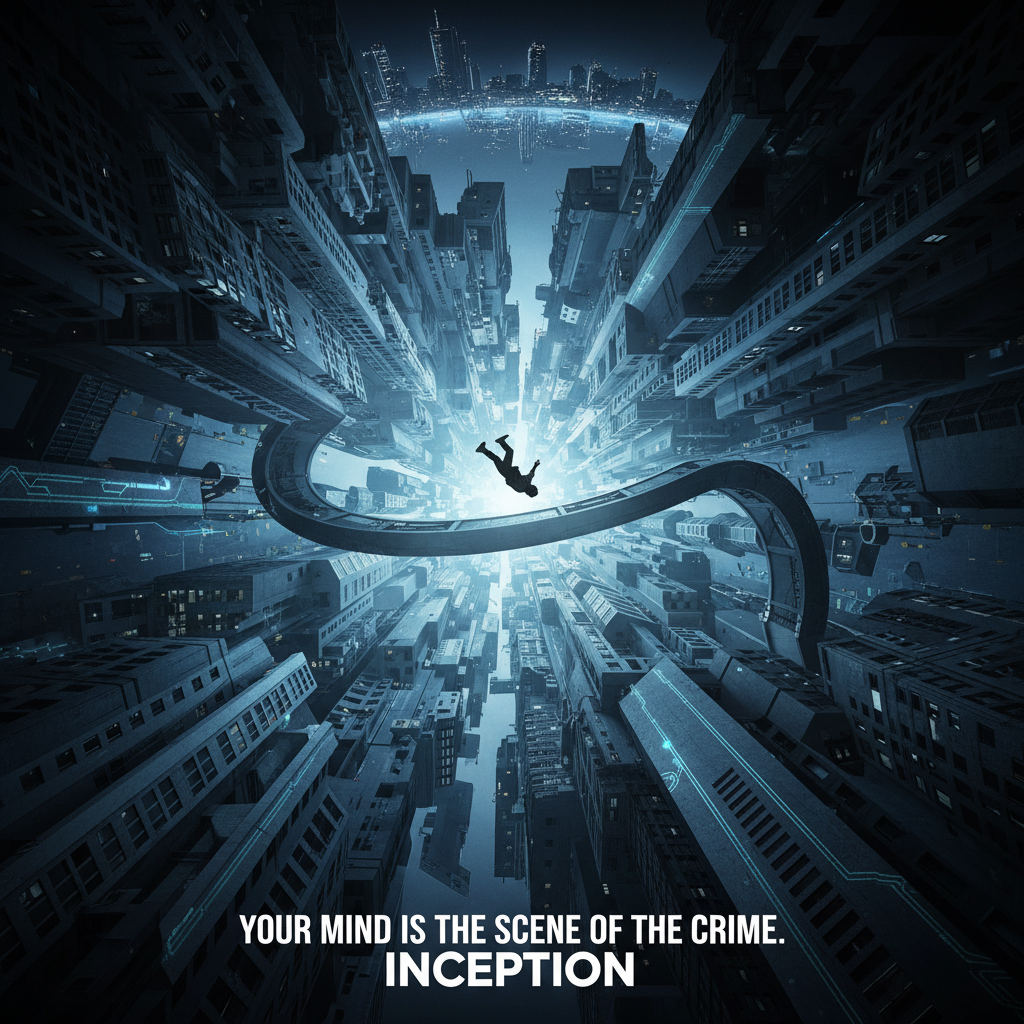

In [150]:
# Task 8c: Display the saved image (5 pts)
from IPython.display import Image, display

# YOUR CODE HERE - display the poster you saved
if output_path.exists():
    display(Image(filename=str(output_path), width=400))
else:
    print("Run the previous cell first to generate the image!")

---

## Task 9: Submit via Pull Request (15 points)

Now let's practice a real-world development workflow! Instead of pushing directly to `main`, you'll create a **branch**, open a **Pull Request (PR)**, and **merge** it.

This is how professional developers submit code for review. Your TA will check your merged PR to verify your submission.

### 9a. Create a new branch (5 pts)

Run this command in your terminal to create and switch to a new branch:

In [ ]:
# Task 9a: Create a new branch (5 pts)
# Run this in your terminal (not in this notebook!)

!git checkout -b homework-2

### 9b. Commit your work (5 pts)

Stage all your changes and create a commit:

In [ ]:
# Task 9b: Commit your work (5 pts)

!git add .
!git commit -m "Complete homework 2: Movie Poster Generator"

In [ ]:
# Task 9c: Push your branch (5 pts)

!git push -u origin homework-2

### 9d. Create and Merge the Pull Request

Now go to your repository on GitHub (https://github.com/YOUR-USERNAME/ai-engineering-fordham):

1. You should see a banner saying **"homework-2 had recent pushes"** - click **"Compare & pull request"**
2. Give your PR a title: `"Homework 2: Movie Poster Generator"`
3. Click **"Create pull request"**
4. Review your changes in the PR
5. Click **"Merge pull request"** then **"Confirm merge"**

**Your PR should now show as "Merged"** - this is what the TA will check!

Run the cell below to verify your branch was merged:

In [ ]:
# Verify your PR was merged (run after merging on GitHub)
!git checkout main
!git pull
!git log --oneline -3

---

## BONUS: Full Pipeline (10 bonus points)

Put everything together! Create a complete pipeline that takes a movie description and returns both the structured data AND a generated poster.

**Challenge:** Write your own original movie description and generate a poster for it!

In [ ]:
# BONUS: Create a complete pipeline (10 bonus pts)

async def movie_to_poster(description: str) -> tuple[Movie, str]:
    """
    Complete pipeline: description -> structured data -> poster
    
    Args:
        description: A text description of a movie
        
    Returns:
        Tuple of (Movie object, path to saved poster image)
    """
    # YOUR CODE HERE
    pass

In [ ]:
# Test with YOUR OWN original movie idea!

my_movie_description = """
YOUR ORIGINAL MOVIE IDEA HERE - BE CREATIVE!
Describe the plot, characters, setting, visual style, and mood.
"""

# Uncomment to run:
# movie, poster_path = await movie_to_poster(my_movie_description)
# print(f"Generated poster for: {movie.title}")
# print(movie.model_dump_json(indent=2))
# display(Image(poster_path))

---

## Submission Checklist

Before submitting, make sure:

- [ ] All code cells run without errors
- [ ] Your `Movie` schema includes all required fields with proper validation
- [ ] `extract_movie()` returns a valid `Movie` object
- [ ] Async processing works and shows timing
- [ ] Temperature comparison shows deterministic vs random outputs
- [ ] Logprobs visualization works and displays token probabilities
- [ ] Reasoning model comparison shows differences between o3-mini and gpt-5-mini
- [ ] You generated and displayed at least one movie poster
- [ ] Created branch `homework-2` and pushed to GitHub
- [ ] Opened a Pull Request from `homework-2` to `main`
- [ ] **Merged the PR** (it should show as "Merged" on GitHub)
- [ ] Submitted notebook on Blackboard

**Submission:**
1. Complete all tasks in this notebook
2. Create a PR and **merge it** on GitHub
3. Submit your notebook (`.ipynb` file) on **Blackboard**

**The TA will verify your submission by checking the merged PR on your GitHub repo.**

---

**Great work!** You've built a complete AI-powered application, explored LLM parameters and reasoning, and learned a professional Git workflow!